In [141]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import tensorflow as tf
import collections

if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.cliff_walking import CliffWalkingEnv
from lib import plotting

matplotlib.style.use('ggplot')


In [142]:
env = gym.make('CartPole-v0')


In [143]:
dim = max(np.shape(env.observation_space))
dim_actions = env.action_space.n
env.observation_space.shape

env.reward_range


(-inf, inf)

In [144]:
class PolicyEstimator():
    """
    Policy Function approximator. 
    """
    
    def __init__(self, learning_rate=0.01, scope="policy_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, shape=[None, dim], name="state")
            self.action = tf.placeholder(dtype=tf.int32, name="action")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just table lookup estimator
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=self.state,
                num_outputs=dim_actions,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)

            self.action_probs = tf.squeeze(tf.nn.softmax(self.output_layer))
            self.picked_action_prob = tf.gather(self.action_probs, self.action)

            # Loss and train op
            self.loss = -tf.log(self.picked_action_prob) * self.target

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        
        state = np.reshape(state,(1,dim)) # Change the observation file to input
            
        return sess.run(self.action_probs, feed_dict={ self.state: state })

    def update(self, state, target, action, sess=None):
        sess = sess or tf.get_default_session()
        
        state = np.reshape(state,(1,dim)) # Change the observation file to input

        
        feed_dict = { self.state: state, self.target: target, self.action: action  }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [145]:
class ValueEstimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self, learning_rate=0.1, scope="value_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, shape=[None, dim], name="state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just table lookup estimator
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=self.state,
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)

            self.value_estimate = tf.squeeze(self.output_layer)
            self.loss = tf.squared_difference(self.value_estimate, self.target)

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())        
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
                
        state = np.reshape(state,(1,dim)) # Change the observation file to input
        
        return sess.run(self.value_estimate, { self.state: state })

    def update(self, state, target, sess=None):
        sess = sess or tf.get_default_session()
        
        state = np.reshape(state,(1,dim)) # Change the observation file to input

        
        feed_dict = { self.state: state, self.target: target }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [152]:
def reinforce(env, estimator_policy, estimator_value, num_episodes, discount_factor=1):
    """
    REINFORCE (Monte Carlo Policy Gradient) Algorithm. Optimizes the policy
    function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized 
        estimator_value: Value function approximator, used as a baseline
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    for i_episode in range(num_episodes):
        # Reset the environment and pick the fisrst action
        state = env.reset()
        
        #print(state)
        
        episode = []
        
        # One step in the environment
        for t in itertools.count():
            
            # Take a step
            action_probs = estimator_policy.predict(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            
            next_state, reward, done, _ = env.step(action)
            
            #env.render()
            
            # Keep track of the transition
            episode.append(Transition(
              state=state, action=action, reward=reward, next_state=next_state, done=done))
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            #print(reward)
            stats.episode_lengths[i_episode] = t
            
            # Print out which step we're on, useful for debugging.
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")
            # sys.stdout.flush()

            if done:
                break
                
            state = next_state
    
        # Go through the episode and make policy updates
        for t, transition in enumerate(episode):
            # The return after this timestep
            total_return = sum(discount_factor**i * t.reward for i, t in enumerate(episode[t:]))
            #print(total_return)
            # Calculate baseline/advantage
            baseline_value = estimator_value.predict(transition.state)            
            advantage = total_return - baseline_value
            # Update our value estimator
            estimator_value.update(transition.state, total_return)
            # Update our policy estimator
            estimator_policy.update(transition.state, advantage, transition.action)
    
    return stats

In [ ]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator()
value_estimator = ValueEstimator()

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    # Note, due to randomness in the policy the number of episodes you need to learn a good
    # policy may vary. ~2000-5000 seemed to work well for me.
    stats = reinforce(env, policy_estimator, value_estimator, 2000, discount_factor=1.0)
    
    
    ## TEST THE OBTAINED POLICY

    state = env.reset()

    while(1):

        # Take a step
        action_probs = policy_estimator.predict(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

        next_state, reward, done, _ = env.step(action)
        env.render()

        if done:
            break

        state = next_state

Step 47 @ Episode 1/2000 (0.0)48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 24 @ Episode 2/2000 (48.0)25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 57 @ Episode 3/2000 (25.0)58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 50 @ Episode 4/2000 (58.0)51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Ste

77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 130 @ Episode 32/2000 (91.0)131.0
130.0
129.0
128.0
127.0
126.0
125.0
124.0
123.0
122.0
121.0
120.0
119.0
118.0
117.0
116.0
115.0
114.0
113.0
112.0
111.0
110.0
109.0
108.0
107.0
106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0

101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 96 @ Episode 51/2000 (150.0)97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2

Step 88 @ Episode 72/2000 (191.0)89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 75 @ Episode 73/2000 (89.0)76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 77 @ Episode 74/2000 (76.0)78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
5

142.0
141.0
140.0
139.0
138.0
137.0
136.0
135.0
134.0
133.0
132.0
131.0
130.0
129.0
128.0
127.0
126.0
125.0
124.0
123.0
122.0
121.0
120.0
119.0
118.0
117.0
116.0
115.0
114.0
113.0
112.0
111.0
110.0
109.0
108.0
107.0
106.0
105.0
104.0
103.0
102.0
101.0
100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 175 @ Episode 88/2000 (200.0)176.0
175.0
174.0
173.0
172.0
171.0
170.0
169.0
168.0
167.0
166.0
165.0
164.0
163.0
162.0
161.0
160.0
159.0
158.0
157.0
156.0
155.0
154.0
153.0
152.0
151.0
150.0
149.0
148.0
147.0
146.0
145.0
144.0
143.0
142.0
141.0
140.0


8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 89 @ Episode 101/2000 (99.0)90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 64 @ Episode 102/2000 (90.0)65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 69 @ Episode 103/2000 (65.0)70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48

19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 25 @ Episode 117/2000 (30.0)26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 48 @ Episode 118/2000 (26.0)49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 43 @ Episode 119/2000 (49.0)44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 21 @ Episode 120/2000 (44.0)22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
Step 32 @ Episode 121/2000 (22.0)33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0


In [154]:
env.close()

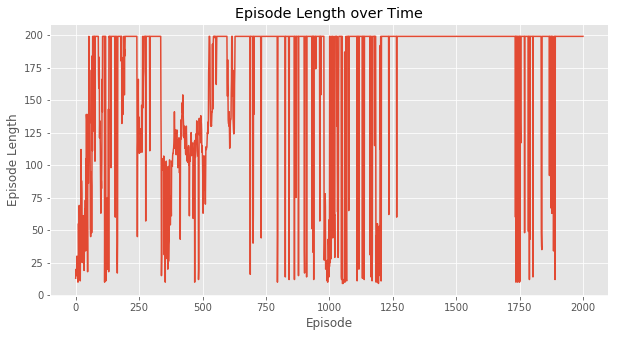

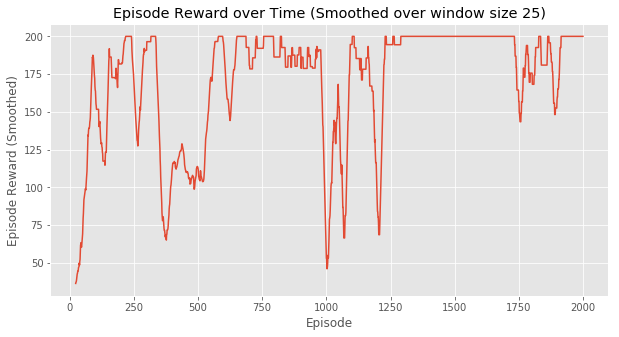

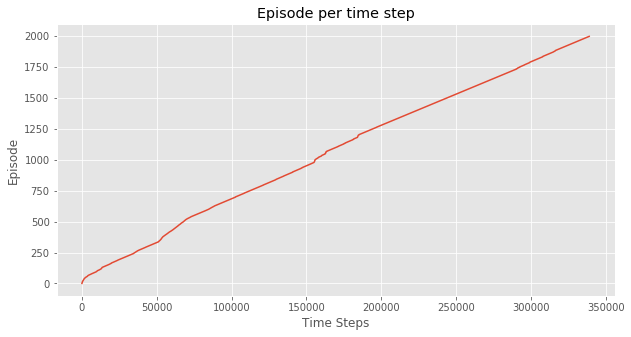

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [155]:
plotting.plot_episode_stats(stats, smoothing_window=25)

In [148]:
## TEST THE EFFECT OF DISCOUNT FACTOR

ones = np.ones(200)

discount = 0.9

total_return = sum(discount**i * t for i, t in enumerate(ones[:]))


FailedPreconditionError: Attempting to use uninitialized value policy_estimator/fully_connected/weights
	 [[node policy_estimator/fully_connected/weights/read (defined at /home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/variables.py:277)  = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](policy_estimator/fully_connected/weights)]]

Caused by op 'policy_estimator/fully_connected/weights/read', defined at:
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/asyncio/base_events.py", line 427, in run_forever
    self._run_once()
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/asyncio/base_events.py", line 1440, in _run_once
    handle._run()
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-147-892e2e841ae0>", line 4, in <module>
    policy_estimator = PolicyEstimator()
  File "<ipython-input-144-3c980d6a6ef1>", line 17, in __init__
    weights_initializer=tf.zeros_initializer)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/contrib/layers/python/layers/layers.py", line 1854, in fully_connected
    outputs = layer.apply(inputs)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 817, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 374, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 746, in __call__
    self.build(input_shapes)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py", line 944, in build
    trainable=True)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 288, in add_weight
    getter=vs.get_variable)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 609, in add_weight
    aggregation=aggregation)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/training/checkpointable/base.py", line 639, in _add_variable_with_custom_getter
    **kwargs_for_getter)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1487, in get_variable
    aggregation=aggregation)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1237, in get_variable
    aggregation=aggregation)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 523, in get_variable
    return custom_getter(**custom_getter_kwargs)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/contrib/layers/python/layers/layers.py", line 1749, in layer_variable_getter
    return _model_variable_getter(getter, *args, **kwargs)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/contrib/layers/python/layers/layers.py", line 1740, in _model_variable_getter
    aggregation=aggregation)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/variables.py", line 350, in model_variable
    aggregation=aggregation)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/variables.py", line 277, in variable
    aggregation=aggregation)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 492, in _true_getter
    aggregation=aggregation)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 922, in _get_single_variable
    aggregation=aggregation)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 183, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 146, in _variable_v1_call
    aggregation=aggregation)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 125, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2444, in default_variable_creator
    expected_shape=expected_shape, import_scope=import_scope)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 187, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 1329, in __init__
    constraint=constraint)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 1491, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 81, in identity
    return gen_array_ops.identity(input, name=name)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3454, in identity
    "Identity", input=input, name=name)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value policy_estimator/fully_connected/weights
	 [[node policy_estimator/fully_connected/weights/read (defined at /home/jurain/anaconda3/envs/rl36/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/variables.py:277)  = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](policy_estimator/fully_connected/weights)]]


AttributeError: 'NoneType' object has no attribute 'run'